# Hair style segmentation (part 1 of hairstyle swap)

## Set up Google Colab

In [0]:
%ls

In [0]:
from google.colab import drive 
drive.mount("bdrive")

In [0]:
cd bdrive/My\ Drive/app/Hair-segmentation/

In [0]:
from PIL import Image
Image.open(open("images/works.jpg", "rb"))

In [0]:
!pip install torch torchvision

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
import random 

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim
from torch.utils.data import Dataset

from torchvision import models, transforms, utils
from torchvision.models.vgg import VGG

## Data 

### Load dataset

In [0]:
class PartLFW(Dataset):
  
  def __init__(self, csv_file, phase):
    self.phase = phase
    self.data = pd.read_csv(csv_file)
    
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 0], self.data.iloc[index, 1]
    image = scipy.misc.imread(image, mode='RGB')
    label = np.load(label)
    # Normalization 
    mean = [29.24429131, 29.24429131, 29.24429131]
    std = [69.8833313, 63.37436676, 61.38568878]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]    
   
    # ToTensor
    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).long()
       
    # One-hot encoding 
    h, w = label.size()
    target = torch.zeros(3, h, w) 
    for c in range(3):
      target[c][label == c] = 1
      
    return {'x': image, 'y':target, 'l':label}
    
  def __len__(self):
    return len(self.data)
  
train_data = PartLFW("data/LFW/training.csv", phase="train")
valid_data = PartLFW("data/LFW/validation.csv", phase="valid")
test_data = PartLFW("data/LFW/test.csv", phase="test")

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

### Visualize dataset sample

torch.Size([32, 3, 500, 500]) torch.Size([32, 3, 500, 500]) torch.Size([32, 500, 500])


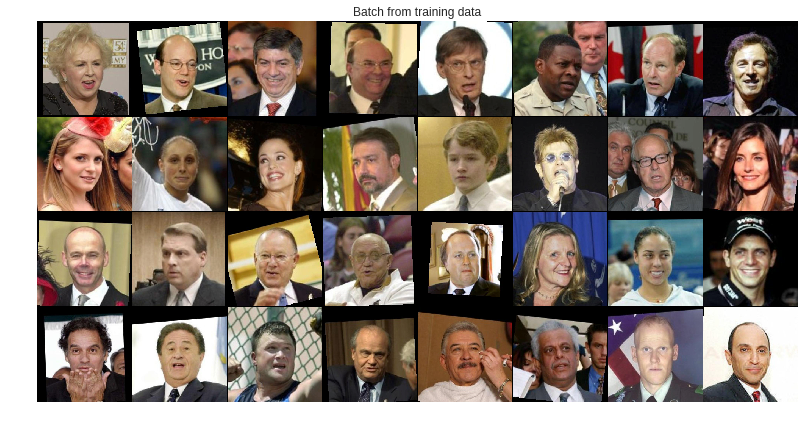

In [8]:
def show_batch(batch):
  mean = [29.24429131, 29.24429131, 29.24429131]
  std = [69.8833313, 63.37436676, 61.38568878]
  
  img_batch = batch['x']
 
  # Desnormalize 
  img_batch[:,0,...].mul_(std[0]).add_(mean[0])
  img_batch[:,1,...].mul_(std[1]).add_(mean[1])
  img_batch[:,2,...].mul_(std[2]).add_(mean[2])
  
  img_batch = np.clip(img_batch, 0, 1)
  grid = utils.make_grid(img_batch)
  
  plt.rcParams['figure.figsize'] = [20, 7.0]
  plt.figure()
  plt.title('Batch from training data')
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.ioff()
  plt.show
    
batch = next(iter(trainloader))
print(batch['x'].size(), batch['y'].size(), batch['l'].size())
show_batch(batch)

## Model

### Encoder 

In [0]:
class VGG16(VGG):
  
  def __init__(self, pretrained=True, requires_grad=True, remove_fc=True, padding=True, show_params=False):
    super().__init__(self.make_layers())
        
    if pretrained:
      exec("self.load_state_dict(models.vgg16(pretrained=True).state_dict())")
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if padding:
      self.features[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=100)
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    ranges = ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))
    output = {}
    for idx in range(len(ranges)):
      for layer in range(ranges[idx][0], ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, batch_norm=False):
    cfg = [64, 64, 'M',
           128, 128, 'M', 
           256, 256, 256, 'M', 
           512, 512, 512, 'M', 
           512, 512, 512, 'M']
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

### Decoder 

In [0]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    
    # fc6 of VGG16
    self.fc6 = nn.Conv2d(512, 4096, 7)
    self.relu6 = nn.ReLU(inplace=True)
    self.drop6 = nn.Dropout2d()
    
    # fc7 of VGG16 
    self.fc7 = nn.Conv2d(4096, 4096, 1)
    self.relu7 = nn.ReLU(inplace=True)
    self.drop7 = nn.Dropout2d()
    
    # Convolutional score layer 
    self.score_fr = nn.Conv2d(4096, n_classes, 1)
    
    # Upsampling (Deconvolutions)
    self.score_pool3 = nn.Conv2d(256, n_classes, 1)
    self.score_pool4 = nn.Conv2d(512, n_classes, 1)
    
    self.upscore2 = nn.ConvTranspose2d(n_classes, n_classes,  4, stride=2, bias=False)
    self.upscore8 = nn.ConvTranspose2d(n_classes, n_classes, 16, stride=8, bias=False)
    
    self.upscore_pool4 = nn.ConvTranspose2d(n_classes, n_classes, 4, stride=2, bias=False)
  
  def forward(self, x):
    img = x
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu6(self.fc6(pool_5))
    x = self.drop6(x)
    
    x = self.relu7(self.fc7(x))
    x = self.drop7(x)
    
    x = self.score_fr(x)
    x = self.upscore2(x)
    upscore2 = x
        
    x = self.score_pool4(pool_4)
    x = x[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
    score_pool4 = x
    
    x = upscore2 + score_pool4
    x = self.upscore_pool4(x)
    upscore_pool4 = x
    
    x = self.score_pool3(pool_3)
    x = x[:, :, 9:9 + upscore_pool4.size()[2], 9:9 + upscore_pool4.size()[3]]
    score_pool3 = x
    
    x = upscore_pool4 + score_pool3
    
    x = self.upscore8(x)
    
    x = x[:, :, 31:31 + img.size()[2], 31:31 + img.size()[3]].contiguous()
    
    return x

### Test shapes

In [8]:
batch, n_classes, height, width = 1, 3, 500, 500

model = FCN8s(VGG16(), n_classes)
input_img = torch.rand(batch, n_classes, height, width)
out_pred = model(input_img)

assert out_pred.size() == torch.Size([batch, n_classes, height, width])
print("correct shapes")


correct shapes
